an exploration of the SuperContest results. are these people better than random at betting on sports? what trends exist?

I previously wrote a bunch of tedious code to screen-scrape results from various websites & the internet archive but it turns out there's a site with the rankings and a wonderful 'export csv' option

This goes back to at least 2013. so cool.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import scipy.stats

from statsmodels.stats.proportion import proportion_confint

import time

In [4]:


url_template = "https://fantasysupercontest.com/supercontest-standings-%(yyyy)s-week-18?year=%(yyyy)s&limit=all&trend=all&team_option=text&format=csv"

might as well go pokemon and catch 'em all

In [5]:
dates = list(range(2013,2026))

In [6]:
for yyyy in dates:
    print(url_template % locals())

https://fantasysupercontest.com/supercontest-standings-2013-week-18?year=2013&limit=all&trend=all&team_option=text&format=csv
https://fantasysupercontest.com/supercontest-standings-2014-week-18?year=2014&limit=all&trend=all&team_option=text&format=csv
https://fantasysupercontest.com/supercontest-standings-2015-week-18?year=2015&limit=all&trend=all&team_option=text&format=csv
https://fantasysupercontest.com/supercontest-standings-2016-week-18?year=2016&limit=all&trend=all&team_option=text&format=csv
https://fantasysupercontest.com/supercontest-standings-2017-week-18?year=2017&limit=all&trend=all&team_option=text&format=csv
https://fantasysupercontest.com/supercontest-standings-2018-week-18?year=2018&limit=all&trend=all&team_option=text&format=csv
https://fantasysupercontest.com/supercontest-standings-2019-week-18?year=2019&limit=all&trend=all&team_option=text&format=csv
https://fantasysupercontest.com/supercontest-standings-2020-week-18?year=2020&limit=all&trend=all&team_option=text&for

In [7]:
test_df = pd.read_csv(url_template % {'yyyy':2024})

In [8]:
test_df.head()

,rank,name,pick1,pick2,pick3,pick4,pick5,week_win,week_loss,week_push,season_win,season_lost,season_push,win%,points,order
0,1,WALKAMIN,BAL,PIT,BUF,DEN,HOU,3,2,0,60,29,1,67.4,60.5,1
1,2,EXCELLENTO,MIA,LAR,HOU,DET,PHI,4,1,0,59,29,2,67.0,60.0,2
2,3,TA2 RG,TB,LAC,CAR,TEN,DET,3,2,0,58,30,2,65.9,59.0,3
3,3,MEYER LANDSCAQPING,TB,GB,DEN,ATL,WAS,1,4,0,58,30,2,65.9,59.0,4
4,3,LOCA LOSERS,CIN,TB,GB,LAC,WAS,2,3,0,57,29,4,66.3,59.0,5


I don't care about the picks, will drop them

In [9]:
test_df = test_df.drop(['pick%s' % i for i in range(1,6)], axis=1)

In [10]:
test_df['win%'].describe()

count    1036.000000
mean       50.756564
std         6.009936
min        33.700000
25%        46.600000
50%        50.600000
75%        54.700000
max        67.400000
Name: win%, dtype: float64

<Axes: >

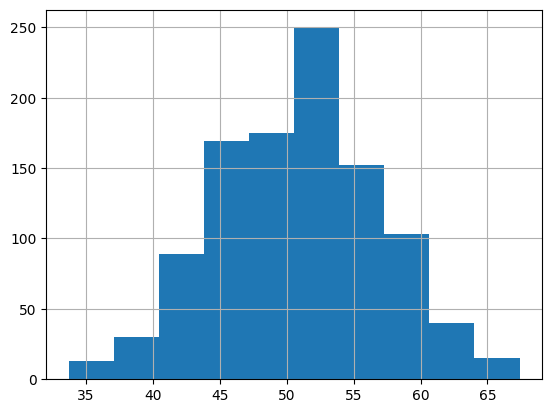

In [11]:
test_df['win%'].hist()

fetch all available data here

In [12]:
test_df.head()

,rank,name,week_win,week_loss,week_push,season_win,season_lost,season_push,win%,points,order
0,1,WALKAMIN,3,2,0,60,29,1,67.4,60.5,1
1,2,EXCELLENTO,4,1,0,59,29,2,67.0,60.0,2
2,3,TA2 RG,3,2,0,58,30,2,65.9,59.0,3
3,3,MEYER LANDSCAQPING,1,4,0,58,30,2,65.9,59.0,4
4,3,LOCA LOSERS,2,3,0,57,29,4,66.3,59.0,5


In [13]:
dataframes = {}

for yyyy in dates:
    df = pd.read_csv(url_template % locals())
    df['year'] = yyyy
    dataframes[yyyy] = df
    time.sleep(2) # be polite

In [14]:
dataframes.keys()

dict_keys([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [15]:
all_years = pd.concat(dataframes.values())

let's do some ETL

In [16]:
#all_years = all_years.drop(['pick%s' % i for i in range(1,6)], axis=1)

all_years['win_pct'] = all_years['win%']
all_years = all_years.drop(['win%'], axis=1)

# number of units won/lost betting at -110
all_years['units'] = all_years.season_win - (1.1 * all_years.season_lost)


#all_years['return_rate'] = all_years.units / all_years

In [17]:
# number of games bet, including pushes
all_years['n_games'] = all_years.season_win + all_years.season_lost + all_years.season_push

## rate of return -- profit/loss relative to amount risked @ -110 vig

# over all bets taken, including PUSHes
all_years['return_rate'] = all_years.units / (1.1 * all_years.n_games)

In [18]:
all_years.return_rate.describe()

count    20576.000000
mean        -0.025042
std          0.102893
min         -0.449198
25%         -0.096970
50%         -0.022460
75%          0.044920
max          0.449198
Name: return_rate, dtype: float64

<Axes: >

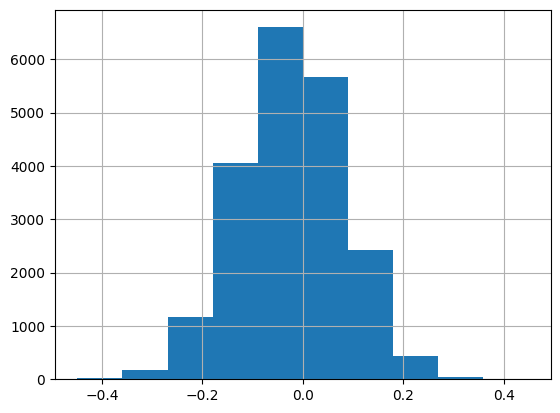

In [19]:
all_years.return_rate.hist()

In [20]:
all_years.head()


,rank,name,pick1,pick2,pick3,pick4,pick5,week_win,week_loss,week_push,season_win,season_lost,season_push,points,order,year,win_pct,units,n_games,return_rate
0,1,DAVID FROHARDT -LANE 2,NaN,NaN,NaN,NaN,NaN,4,1,0,55,26,4,57.0,1,2013,67.9,26.4,85,0.282353
1,2,EBN OZN,NaN,NaN,NaN,NaN,NaN,3,2,0,56,28,1,56.5,2,2013,66.7,25.2,85,0.269519
2,3,BOSCO 78,NaN,NaN,NaN,NaN,NaN,5,0,0,54,29,2,55.0,3,2013,65.1,22.1,85,0.236364
3,4,BITTER BOB,NaN,NaN,NaN,NaN,NaN,5,0,0,53,29,3,54.5,4,2013,64.6,21.1,85,0.225668
4,4,BIG LIB,NaN,NaN,NaN,NaN,NaN,3,2,0,53,29,3,54.5,5,2013,64.6,21.1,85,0.225668


In [21]:
all_years.win_pct.describe()

count    20577.000000
mean        51.032143
std          5.539958
min          0.000000
25%         47.200000
50%         51.200000
75%         54.800000
max         76.200000
Name: win_pct, dtype: float64

In [22]:
wp = all_years.groupby('year')['win_pct'].describe()
wp

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,838.0,50.206683,5.574601,34.6,46.300,50.00,54.2,67.9
2014,1135.0,52.090925,5.595253,35.3,48.200,51.80,56.0,76.2
2015,1376.0,51.867660,5.250818,35.8,48.200,51.85,55.4,72.0
2016,1615.0,50.297399,5.207277,29.3,46.900,50.60,54.1,65.9
2017,2406.0,50.892727,5.516971,31.7,47.000,51.20,54.8,72.5
2018,2802.0,52.158887,5.634947,30.0,48.200,52.40,56.0,70.2
2019,3040.0,50.358092,5.500496,28.6,46.900,50.00,54.2,69.9
2020,1077.0,49.724977,5.119125,34.1,46.300,50.00,53.1,67.5
2021,1819.0,51.412314,5.412610,30.0,47.800,51.70,55.1,69.3


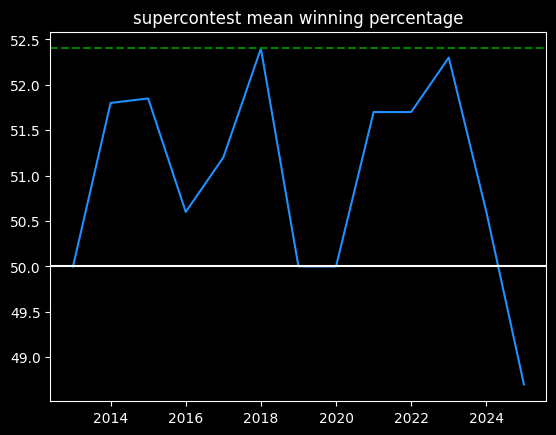

In [23]:
#all_years.groupby('year')['win_pct'].quantile(.05).plot()
plt.style.use('dark_background')

plt.plot(all_years.groupby('year')['win_pct'].quantile(.5), color='dodgerblue')
plt.title("supercontest mean winning percentage")
plt.axhline(50)
plt.axhline(52.4, color='green', linestyle='--')


#all_years.groupby('year')['win_pct'].quantile(.95).plot()


In [24]:
all_years.groupby('year')['units'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,838.0,-3.768735,9.644336,-29.3,-10.5,-4.10,3.200,26.4
2014,1135.0,-0.516035,9.891708,-30.5,-7.4,-1.10,6.300,42.0
2015,1376.0,-0.886846,9.177661,-28.2,-7.3,-0.95,5.300,33.7
2016,1615.0,-3.607864,9.016548,-39.8,-9.4,-3.10,3.100,23.2
2017,2406.0,-2.566833,9.499288,-35.6,-9.3,-2.10,4.200,33.8
2018,2802.0,-0.379693,9.749867,-37.8,-7.2,0.00,6.300,31.5
2019,3040.0,-3.502237,9.505018,-42.0,-9.4,-4.10,3.200,30.5
2020,1077.0,-4.554410,8.763935,-31.4,-10.4,-4.20,1.200,25.4
2021,1819.0,-1.801100,10.113597,-42.3,-8.7,-1.30,5.000,31.3


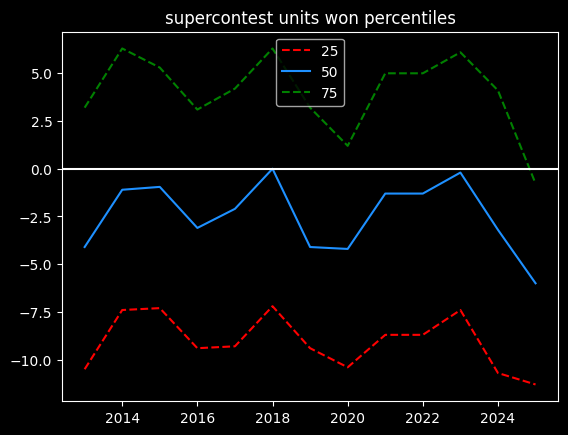

In [25]:
units_group = all_years.groupby('year')['units']

plt.plot(units_group.quantile(.25), color='red', linestyle='--', label='25')
plt.plot(units_group.quantile(.5), color='dodgerblue', label='50')
plt.plot(units_group.quantile(.75), color='green', linestyle='--', label='75')

plt.title("supercontest units won percentiles")
plt.axhline(0)
plt.legend()
#plt.axhline(52.4, color='green', linestyle='--')


In [26]:
all_years.groupby('year')['return_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,838.0,-0.040427,0.103387,-0.330682,-0.112299,-0.043850,0.034225,0.282353
2014,1135.0,-0.005522,0.106009,-0.326203,-0.079144,-0.011765,0.067380,0.449198
2015,1376.0,-0.009542,0.098252,-0.301604,-0.078075,-0.010160,0.056684,0.360428
2016,1615.0,-0.038657,0.096543,-0.425668,-0.100535,-0.033155,0.033155,0.248128
2017,2406.0,-0.027480,0.101716,-0.380749,-0.099465,-0.022460,0.044920,0.361497
2018,2802.0,-0.004214,0.104859,-0.427273,-0.077005,0.000000,0.067380,0.336898
2019,3040.0,-0.037553,0.102080,-0.449198,-0.100535,-0.043850,0.034225,0.326203
2020,1077.0,-0.048914,0.093970,-0.335829,-0.111230,-0.044920,0.012834,0.271658
2021,1819.0,-0.018336,0.102503,-0.427273,-0.087879,-0.013131,0.050505,0.316162


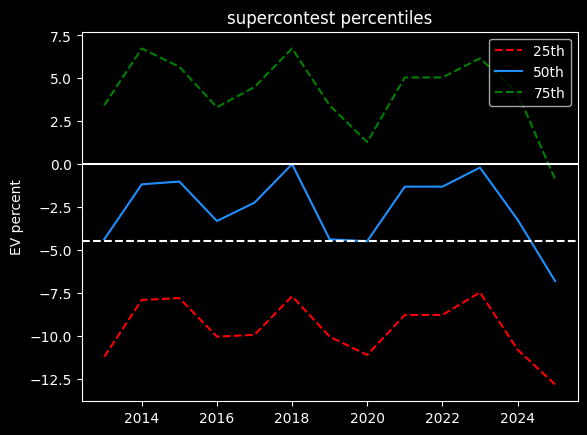

In [ ]:
units_group = all_years.groupby('year')['return_rate']

plt.plot(units_group.quantile(.25) * 100, color='red', linestyle='--', label='25th')
plt.plot(units_group.quantile(.5) * 100, color='dodgerblue', label='50th')
plt.plot(units_group.quantile(.75) * 100, color='green', linestyle='--', label='75th')

plt.title("supercontest percentiles")

plt.ylabel("EV percent")

plt.axhline(0)
plt.axhline(-4.5, linestyle="--")
plt.legend()
#plt.axhline(52.4, color='green', linesty

note: using this method gives weird results (see note at end of notebook)

In [30]:
bt = scipy.stats.binomtest(k = 40, n=80) # 80 here is the number of picks by each player in the season. 
ci = bt.proportion_ci(confidence_level=.5)  # want the CI for 25th & 75th percentile

ci

ConfidenceInterval(low=0.4562680802031627, high=0.5437319197968372)

In [31]:
# CI should roughly be +/- this
1/2/np.sqrt(80)

np.float64(0.05590169943749474)

I needed to change the method of calculating the confidence interval

In [32]:
ci2 = proportion_confint(count=40, nobs=80, alpha=.5)

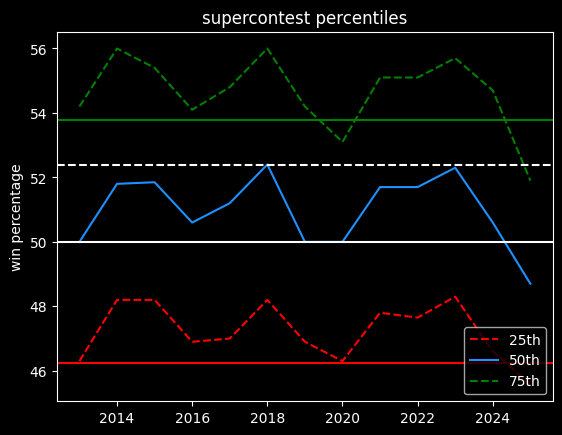

In [60]:


units_group = all_years.groupby('year')['win_pct']

plt.plot(units_group.quantile(.25), color='red', linestyle='--', label='25th')
plt.plot(units_group.quantile(.5), color='dodgerblue', label='50th')
plt.plot(units_group.quantile(.75), color='green', linestyle='--', label='75th')

plt.ylabel("win percentage")

plt.title("supercontest percentiles")
plt.axhline(50)
plt.axhline(52.4, linestyle="--")

plt.axhline(100*ci2[0], color='red')
plt.axhline(100*ci2[1], color='green')

plt.legend(loc='lower right')

In [34]:
units_group.quantile(.5)

year
2013    50.00
2014    51.80
2015    51.85
2016    50.60
2017    51.20
2018    52.40
2019    50.00
2020    50.00
2021    51.70
2022    51.70
2023    52.30
2024    50.60
2025    48.70
Name: win_pct, dtype: float64

### HMMMMM

The 25th/75th percentiles are weird, something going on with the confidence interval.

first I will do simulated results and recreate the above plot

In [35]:
fake_data = all_years.copy()

In [36]:
fake_data.head()

,rank,name,pick1,pick2,pick3,pick4,pick5,week_win,week_loss,week_push,season_win,season_lost,season_push,points,order,year,win_pct,units,n_games,return_rate
0,1,DAVID FROHARDT -LANE 2,NaN,NaN,NaN,NaN,NaN,4,1,0,55,26,4,57.0,1,2013,67.9,26.4,85,0.282353
1,2,EBN OZN,NaN,NaN,NaN,NaN,NaN,3,2,0,56,28,1,56.5,2,2013,66.7,25.2,85,0.269519
2,3,BOSCO 78,NaN,NaN,NaN,NaN,NaN,5,0,0,54,29,2,55.0,3,2013,65.1,22.1,85,0.236364
3,4,BITTER BOB,NaN,NaN,NaN,NaN,NaN,5,0,0,53,29,3,54.5,4,2013,64.6,21.1,85,0.225668
4,4,BIG LIB,NaN,NaN,NaN,NaN,NaN,3,2,0,53,29,3,54.5,5,2013,64.6,21.1,85,0.225668


In [ ]:
#Wfake_data = fake_data.sample(100).copy() # FIXME: diagnostic

In [38]:
fake_data['games_to_sim'] = fake_data.season_win + fake_data.season_lost

fake_data['season_win'] = 0
fake_data['season_lost'] = 0

In [39]:
rng = np.random.default_rng(2718)

In [40]:
for idx, row in fake_data.iterrows():
    season_win = rng.binomial(row.games_to_sim, .5)
    fake_data.loc[idx, 'season_win'] = season_win
    fake_data.loc[idx, 'season_lost'] = row.games_to_sim - season_win

In [41]:
fake_data.games_to_sim

554     80
212     78
230     83
4       83
1303    82
        ..
2445    83
1649    81
1820    81
811     83
1261    83
Name: games_to_sim, Length: 100, dtype: int64

In [42]:
fake_data.win_pct = 100 * ( fake_data.season_win / (fake_data.season_win + fake_data.season_lost))

In [43]:
fake_data.season_lost

554     35
212     48
230     41
4       38
1303    40
        ..
2445    41
1649    39
1820    42
811     39
1261    38
Name: season_lost, Length: 100, dtype: int64

In [44]:
bt = scipy.stats.binomtest(k = 45, n=90) # 80 here is the number of picks by each player in the season. 
ci = bt.proportion_ci(confidence_level=.5)  # want the CI for 25th & 75th percentile

ci

ConfidenceInterval(low=0.45908020694837826, high=0.5409197930516217)

In [45]:
fake_data.n_games

554     85
212     80
230     85
4       85
1303    85
        ..
2445    85
1649    85
1820    85
811     85
1261    85
Name: n_games, Length: 100, dtype: int64

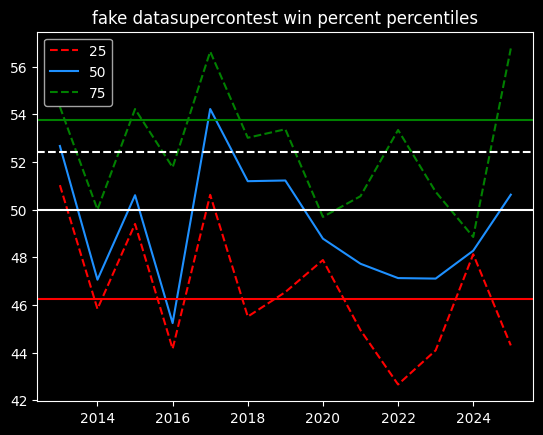

In [46]:
ci2 = proportion_confint(count=40, nobs=80, alpha=.5)

units_group = fake_data.groupby('year')['win_pct']

plt.plot(units_group.quantile(.25), color='red', linestyle='--', label='25')
plt.plot(units_group.quantile(.5), color='dodgerblue', label='50')
plt.plot(units_group.quantile(.75), color='green', linestyle='--', label='75')

plt.title("fake datasupercontest win percent percentiles")
plt.axhline(50)
plt.axhline(52.4, linestyle="--")

plt.axhline(100*ci2[0], color='red')
plt.axhline(100*ci2[1], color='green')

plt.legend()

In [47]:
fake_data[fake_data.games_to_sim > 80].groupby('year')['games_to_sim'].mean()

year
2013    82.500000
2014    84.285714
2015    83.000000
2016    83.400000
2017    82.692308
2018    83.090909
2019    82.555556
2020    82.666667
2021    89.222222
2022    88.333333
2023    86.400000
2024    86.750000
Name: games_to_sim, dtype: float64

ok, so I'm getting weird behavior with the 50% confidence interval. there's something I'm not understanding here (which is great, because that's a chance to learn)

In [48]:
asdf = pd.Series(rng.binomial(80, .5, 10000))

In [49]:
exact_25 = asdf.quantile(.25) / 80

In [50]:
exact_75 = asdf.quantile(.75) / 80

In [51]:
(exact_25, exact_75)

(np.float64(0.4625), np.float64(0.5375))

note this goes from .456 to .544, which is awful close, but doesn't 'exactly' match the data

In [52]:
bt = scipy.stats.binomtest(k = 40, n=80) # 80 here is the number of picks by each player in the season. 
ci = bt.proportion_ci(confidence_level=.5, method='exact')  # want the CI for 25th & 75th percentile

ci

ConfidenceInterval(low=0.4562680802031627, high=0.5437319197968372)

ok, here's what's going on. the `binom_test` method doesn't agree with `.quantile()` results.  default method matches `quantile()`, but `binom_test` doesn't. 

using statsmodels here instead of scipy

https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html

In [53]:
proportion_confint(count=40, nobs=80, alpha=.5, method='binom_test')

(0.4566834893748469, 0.5433165107709088)

the non-`binom_test` method

In [54]:
proportion_confint(count=40, nobs=80, alpha=.5)

(0.4622948767108677, 0.5377051232891322)

In [55]:
(exact_25, exact_75)

(np.float64(0.4625), np.float64(0.5375))

bajillion stats

In [56]:
all_years

,rank,name,pick1,pick2,pick3,pick4,pick5,week_win,week_loss,week_push,season_win,season_lost,season_push,points,order,year,win_pct,units,n_games,return_rate
0,1,DAVID FROHARDT -LANE 2,NaN,NaN,NaN,NaN,NaN,4,1,0,55,26,4,57.0,1,2013,67.9,26.4,85,0.282353
1,2,EBN OZN,NaN,NaN,NaN,NaN,NaN,3,2,0,56,28,1,56.5,2,2013,66.7,25.2,85,0.269519
2,3,BOSCO 78,NaN,NaN,NaN,NaN,NaN,5,0,0,54,29,2,55.0,3,2013,65.1,22.1,85,0.236364
3,4,BITTER BOB,NaN,NaN,NaN,NaN,NaN,5,0,0,53,29,3,54.5,4,2013,64.6,21.1,85,0.225668
4,4,BIG LIB,NaN,NaN,NaN,NaN,NaN,3,2,0,53,29,3,54.5,5,2013,64.6,21.1,85,0.225668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,732,THISSHOULDBEEASY,NaN,NaN,NaN,NaN,NaN,3,2,0,27,51,2,28.0,732,2025,34.6,-29.1,80,-0.330682
732,732,MAYBACH - 2,NaN,NaN,NaN,NaN,NaN,2,3,0,28,52,0,28.0,733,2025,35.0,-29.2,80,-0.331818
733,734,MR HYDE IS REAL,NaN,NaN,NaN,NaN,NaN,0,5,0,26,52,2,27.0,734,2025,33.3,-31.2,80,-0.354545
734,735,STEVESTROGANOFF - 2,NaN,NaN,NaN,NaN,NaN,1,4,0,26,53,1,26.5,735,2025,32.9,-32.3,80,-0.367045
